# **Garbage Classifier Performance Metrics**
### **ENEL 645**
#### **Group 5: Destin Saba, Cole Cathcart**

Introuction...

In [32]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, datasets
import torch.nn as nn
import numpy as np
import os
from PIL import Image
from transformers import DistilBertTokenizer, DistilBertModel
from torchvision.models import ResNet18_Weights
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, roc_curve, auc
import seaborn as sns

# Check if GPU is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)


cpu


In [20]:
# Set path for test data and best model depending on where the notebook is
# being run

# from google.colab import drive
# drive.mount('/content/drive')
TEST_PATH = "/content/drive/MyDrive/CVPR_2024_dataset_Test"
MODEL_PATH = "/content/drive/MyDrive/best_model.pth"

# TEST_PATH = "/work/TALC/enel645_2025w/garbage_data/CVPR_2024_dataset_Test"
# TEST_PATH = "/path/to/local/dataset"
# MODEL_PATH = "./best_model.pth"


We need to redefine some classes from the python file in order to load and preprocess the test set for our best model:

In [21]:
# Transformations to the test set
transform = {
    "test": transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]),
}

# Tokenizer for text
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Class to preprocess dataset
class ImageTextDataset(Dataset):
    def __init__(self, root_dir, transform=None, tokenizer=None):
        self.dataset = datasets.ImageFolder(root=root_dir, transform=transform)
        self.tokenizer = tokenizer  # Store tokenizer reference

    def __len__(self):
        return len(self.dataset.samples)

    def __getitem__(self, idx):
        img_path, label = self.dataset.samples[idx]

        # Load and transform image
        image = self.dataset.loader(img_path)
        if self.dataset.transform:
            image = self.dataset.transform(image)

        # Extract filename text and tokenize
        filename = os.path.splitext(os.path.basename(img_path))[0]  # Safer file parsing
        filename = filename.replace('_', ' ')
        text_inputs = self.tokenizer(filename, padding="max_length", truncation=True, max_length=32, return_tensors="pt")

        input_ids = text_inputs["input_ids"]
        attention_mask = text_inputs["attention_mask"]
        if input_ids.dim() > 1:
            input_ids = input_ids.squeeze(0)
        if attention_mask.dim() > 1:
            attention_mask = attention_mask.squeeze(0)

        return image, input_ids, attention_mask, label

# Image + text classifier
class ImageTextClassifier(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.0):
        super(ImageTextClassifier, self).__init__()

        # Image feature extractor
        self.image_extractor = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Freeze the weights of the image extractor
        for param in self.image_extractor.parameters():
            param.requires_grad = False

        # Remove the final layer of the image extractor
        self.image_extractor.fc = nn.Identity()

        # Text feature extractor
        self.text_extractor = DistilBertModel.from_pretrained('distilbert-base-uncased')

        # Freeze first 4 layers of the text extractor, unfreeze last 2 for fine-tuning
        for i, param in enumerate(self.text_extractor.parameters()):
            if i < len(list(self.text_extractor.parameters())) - 2:
                param.requires_grad = False
            else:
                param.requires_grad = True

        # Reduce text feature dimensionality
        self.text_fc = nn.Linear(self.text_extractor.config.hidden_size, 256)

        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Classifier (image output size is 512, text output size is 256)
        self.classifier = nn.Linear(512 + 256, num_classes)

    def forward(self, images, input_ids, attention_mask):
        # Extract image features
        image_features = self.image_extractor(images)

        # Extract text features
        text_outputs = self.text_extractor(input_ids=input_ids, attention_mask=attention_mask)

        # Reduce text feature dimensionality
        text_features = text_outputs.last_hidden_state[:, 0, :]
        text_features = self.text_fc(text_features)

        # Concatenate image and text features
        features = torch.cat((image_features, text_features), dim=1)

        # Apply dropout
        features = self.dropout(features)

        # Classify
        output = self.classifier(features)

        return output

def evaluate_model(model, dataloader, criterion, device):
    model.to(device)
    model.eval()
    running_loss = 0.0
    y_true, y_pred = [], []

    with torch.no_grad():
        for images, input_ids, attention_mask, labels in dataloader:
            images, input_ids, attention_mask, labels = (
                images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
            )

            outputs = model(images, input_ids, attention_mask)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Calculate metrics
    avg_loss = running_loss / len(dataloader.dataset)
    accuracy = np.mean(np.array(y_true) == np.array(y_pred))
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    return {
        'loss': avg_loss,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

Next we use our functions to preprocess the test set:

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load datasets
dataset = {
    "test": ImageTextDataset(TEST_PATH, transform=transform["test"], tokenizer=tokenizer),
}

print(f"Test dataset size : {len(dataset['test'])}")

# Create dataloaders
dataloaders = {
    "test": DataLoader(dataset["test"], batch_size=32, shuffle=False),
}

# Load the best model from file
best_model = ImageTextClassifier(num_classes=4)
best_model.load_state_dict(torch.load(MODEL_PATH, map_location=device, weights_only=True))


Using device: cpu
Test dataset size : 3432


<All keys matched successfully>

In [26]:
# Evaluate the model on the test set
test_metrics = evaluate_model(best_model, dataloaders["test"], nn.CrossEntropyLoss(), device)

y_true, y_pred = [], []

with torch.no_grad():
    for images, input_ids, attention_mask, labels in dataloaders["test"]:
        images, input_ids, attention_mask, labels = (
            images.to(device), input_ids.to(device), attention_mask.to(device), labels.to(device)
        )
        outputs = best_model(images, input_ids, attention_mask)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

Finally, we can print the evaluation metrics and visualize the model's performance to aid in analysis:

In [27]:
# Test set metrics
print("\nTest Set Metrics:")
print(f"Loss: {test_metrics['loss']:.4f}")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")


Test Set Metrics:
Loss: 0.7782
Accuracy: 0.7296
Precision: 0.7330
Recall: 0.7296
F1 Score: 0.7174


In [29]:
# Per-class metrics
class_names = dataset['test'].dataset.classes

precision, recall, f1, support = precision_recall_fscore_support(y_true, y_pred)
for i, class_name in enumerate(class_names):
    print(f"{class_name}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1 Score: {f1[i]:.4f}")
    print(f"  Support: {support[i]}")

Black:
  Precision: 0.6636
  Recall: 0.4115
  F1 Score: 0.5080
  Support: 695
Blue:
  Precision: 0.6695
  Recall: 0.8600
  F1 Score: 0.7529
  Support: 1086
Green:
  Precision: 0.7813
  Recall: 0.9212
  F1 Score: 0.8455
  Support: 799
TTR:
  Precision: 0.8253
  Recall: 0.6432
  F1 Score: 0.7230
  Support: 852


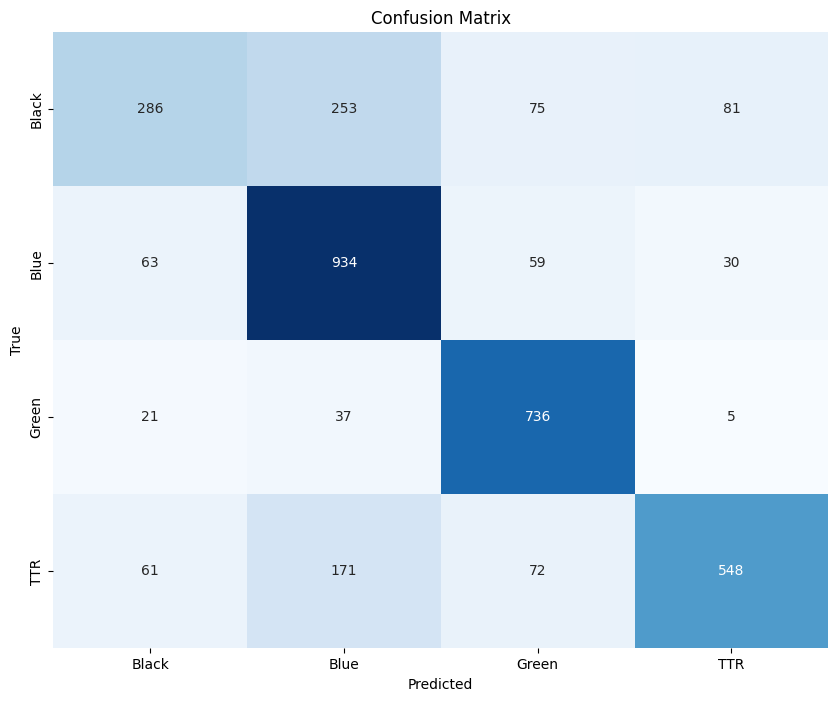

In [40]:
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, cbar=False)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

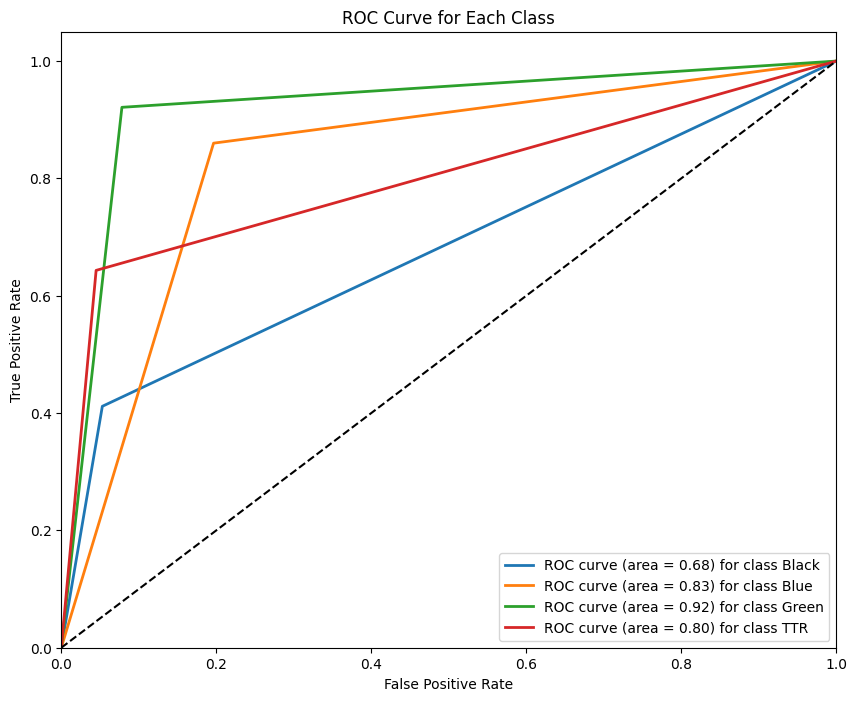

In [39]:
# ROC curve per-class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve((np.array(y_true) == i).astype(int), (np.array(y_pred) == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], class_names[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc="lower right")
plt.show()
